In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# Load the Mendeley dataset
df = pd.read_csv('../data/mendeley_data/HateSpeechDatasetBalanced.csv')

# Split the data into training and testing sets
train_texts, val_test_texts, train_labels, val_test_labels = train_test_split(df['Content'], df['Label'], test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_test_texts, val_test_labels, test_size=0.5, random_state=42)# Create a tokenizer instance
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_texts)

# Convert the text data into sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sqeuences = tokenizer.texts_to_sequences(test_texts)

# Pad the sequences
max_length = 500
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sqeuences , maxlen=max_length, padding='post')

# Clip the padded sequences to ensure indices are within [0, 5000)
train_padded = tf.clip_by_value(train_padded, 0, 5000)
val_padded = tf.clip_by_value(val_padded, 0, 5000)
test_padded = tf.clip_by_value(test_padded, 0, 5000)

# One-hot encode the labels
num_classes = 2
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels, num_classes)


In [2]:
df

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1
...,...,...
726114,i mute this telecasting and played kanye west ...,1
726115,but hell yeah he s not a bachelor but looooooo...,1
726116,great video musician but s not my musician lol...,1
726117,not great pop video yeah he s not a pedophile ...,1


In [7]:

# Define the model architecture
model = Sequential([
    Embedding(input_dim=6000, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the mode
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])

# Train the model
history = model.fit(
    train_padded, train_labels_onehot,
    validation_data=(val_padded, val_labels_onehot),
    epochs=5,
    batch_size=1024,
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_padded, val_labels_onehot)
print(f'Test Accuracy: {test_accuracy:.3f}')



Epoch 1/5


d:\AnaConda\envs\project\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  1/568 ━━━━━━━━━━━━━━━━━━━━ 3:56:37 25s/step - accuracy: 0.5312 - loss: 0.6931

KeyboardInterrupt: 

In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 2)              │       974,018 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 987,466 (3.77 MB)

 Trainable params: 4,482 (17.51 KB)

 Non-trainable params: 974,018 (3.72 MB)

 Optimizer params: 8,966 (35.03 KB)

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Plotting training & validation accuracy and loss
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()
    
    
    

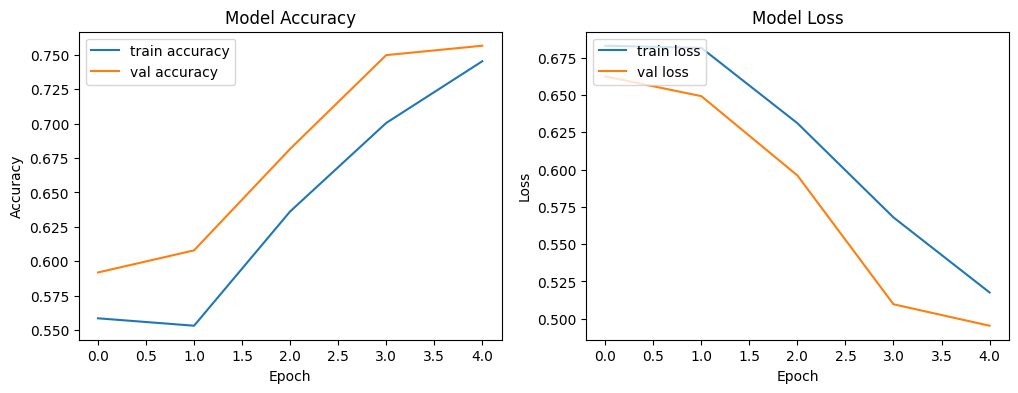

4539/4539 ━━━━━━━━━━━━━━━━━━━━ 948s 209ms/step


In [15]:
plot_history(history)

# Predicting the labels for the test set
test_predictions = (model.predict(test_padded) > 0.5).astype('int32')



Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.59      0.71     72057
           1       0.69      0.93      0.79     73167

    accuracy                           0.76    145224
   macro avg       0.79      0.76      0.75    145224
weighted avg       0.79      0.76      0.75    145224



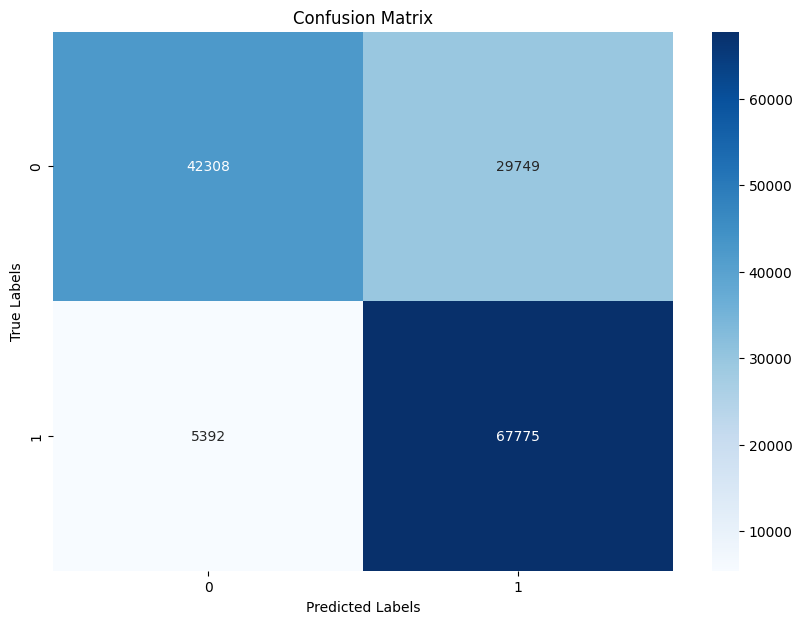

Accuracy: 0.7580
Precision: 0.6950
Recall: 0.9263
F1-Score: 0.7941


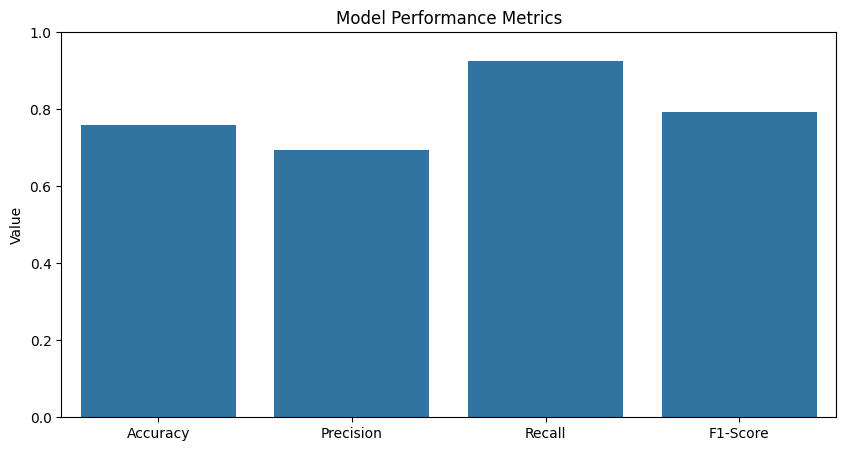

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predicting the labels for the test set
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_classes)

# Classification Report
class_report = classification_report(test_labels, test_predictions_classes, output_dict=True)
print("Classification Report:")
print(classification_report(test_labels, test_predictions_classes))

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Extracting metrics
accuracy = class_report['accuracy']
precision = class_report['1']['precision']
recall = class_report['1']['recall']
f1_score = class_report['1']['f1-score']


# Printing the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


# Plotting the bar chart for accuracy, precision, recall, and F1-score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 5))
sns.barplot(x=metrics, y=values)
plt.title('Model Performance Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)  # Metrics range between 0 and 1
plt.show()


Accuracy: Your model achieves a test accuracy of 0.757, which is a decent score considering the complexity of the Mendeley dataset.

Classification Report: The classification report provides a detailed breakdown of your model's performance on each class. Here are some key takeaways:

Class 0: Your model has a precision of 0.89, recall of 0.59, and F1-score of 0.71 for class 0. This suggests that your model is good at identifying true negatives (class 0) but may be missing some true positives.
Class 1: Your model has a precision of 0.69, recall of 0.93, and F1-score of 0.79 for class 1. This indicates that your model is good at identifying true positives (class 1) but may be misclassifying some true negatives as positives.

Confusion Matrix: The confusion matrix shows that your model is making some mistakes, particularly in the top-right quadrant (false positives) and bottom-left quadrant (false negatives).

Model Performance Metrics: The bar chart shows that your model's accuracy, precision, recall, and F1-score are all around 0.7-0.8, indicating that your model is performing reasonably well but has room for improvement.

Areas for Improvement:

Class imbalance: The Mendeley dataset appears to be imbalanced, with class 0 having slightly more instances than class 1. This can affect your model's performance, particularly if it's biased towards the majority class.
Hyperparameter tuning: You may want to experiment with different hyperparameters, such as the number of epochs, batch size, learning rate, and dropout rates, to see if you can improve your model's performance.
Model architecture: You could try experimenting with different architectures, such as using a Convolutional Neural Network (CNN) or a Transformer-based model, to see if they perform better on this dataset
